# Sistem Rekomendasi Destinasi Wisata dengan Collaborative Filtering
<hr>

#### Sumber data: https://www.kaggle.com/aprabowo/indonesia-tourism-destination

In [1]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

In [2]:
for dirname, _, filenames in os.walk('D:/Dataset Bangkit/archive/'): #membuka file
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:/Dataset Bangkit/archive/package_tourism.csv
D:/Dataset Bangkit/archive/tourism_rating.csv
D:/Dataset Bangkit/archive/tourism_with_id.csv
D:/Dataset Bangkit/archive/user.csv


## 2. Menyiapkan Dataset yang digunakan

In [3]:
# Upload semua dataset yang dipakai
import pandas as pd
rating = pd.read_csv('D:/Dataset Bangkit/archive/tourism_rating.csv')
place = pd.read_csv('D:/Dataset Bangkit/archive/tourism_with_id.csv')
user = pd.read_csv('D:/Dataset Bangkit/archive/user.csv')

##### Keterangan:
* tourism_with_id.csv - mengandung informasi tempak wisata di 5 kota besar di Indonesia
* user.csv - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna
* tourism_rating.csv - mengandung informasi pengguna, tempat wisata, dan rating untuk membuat sistem rekomendasi berdasar rating

kita hanya akan menggunakan place

## 3. Data Understanding


In [4]:
duplicate_rows_df = place[place.duplicated()]
print("number of duplicates : ", duplicate_rows_df)

number of duplicates :  Empty DataFrame
Columns: [Place_Id, Place_Name, Description, Category, City, Price, Rating, Time_Minutes, Coordinate, Lat, Long, Unnamed: 11, Unnamed: 12]
Index: []


In [5]:
# Melihat gambaran data place
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [6]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12', 'Lat', 'Long', 'Coordinate'],axis=1)
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0


In [7]:
# sum over the column axis.
place.City.value_counts(ascending = False)

Yogyakarta    126
Bandung       124
Jakarta        84
Semarang       57
Surabaya       46
Name: City, dtype: int64

In [8]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 27.4+ KB


In [9]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

In [10]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [11]:
# Merubah data rating agar hanya berisi rating pada tempat wisata
rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


In [12]:
# Melihat ukuran dataset rating

rating.shape

(10000, 3)

## 4. Pemodelan Machine Learning dengan Neural Network

In [17]:
# Select relevant features
data_model = place[['Place_Name','City', 'Price','Rating', 'Category','Description']].copy()  # create a copy to avoid SettingWithCopyWarning

# Rescale the ratings to be between 1 and 5
data_model['Rating'] = data_model['Rating'].apply(lambda x: round(x/2) if x <= 10 else 5)

# Handle duplicates and missing data
data_model.drop_duplicates(inplace=True)
data_model.dropna(inplace=True)

# Split into features and target
X = place[['City','Price']]
y = place['Rating']

# Convert City to one-hot encoding
X = pd.get_dummies(X, columns=['City'])

# Convert y to categorical
y = tf.keras.utils.to_categorical(y-1, num_classes=5)

# Split into train, test, and validation sets (50% train, 20% validation, 30% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(0.2/0.7), random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print('Train Accuracy: ', max(history.history['accuracy']))
print('Validation Accuracy: ', max(history.history['val_accuracy']))
print('Train Loss: ', min(history.history['loss']))
print('Validation Loss: ', min(history.history['val_loss']))

Epoch 1/100
7/7 [==============================] - 2s 94ms/step - loss: 1.3165 - accuracy: 0.6912 - val_loss: 1.2095 - val_accuracy: 0.8182
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 1.1290 - accuracy: 0.8848 - val_loss: 1.0307 - val_accuracy: 0.9432
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.9572 - accuracy: 0.9677 - val_loss: 0.8661 - val_accuracy: 0.9545
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7997 - accuracy: 0.9816 - val_loss: 0.7250 - val_accuracy: 0.9545
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.6635 - accuracy: 0.9816 - val_loss: 0.6063 - val_accuracy: 0.9545
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.5486 - accuracy: 0.9816 - val_loss: 0.5062 - val_accuracy: 0.9545
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.4479 - accuracy: 0.9816 - val_loss: 0.4246 - val_accuracy: 0.9545
Epoch 8/100
7/7 [===

## 5. Save Model and Scaler

In [18]:
data_model.to_hdf('wisata_model_baru.h5', key='df', mode='w')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Graph Accuracy Model

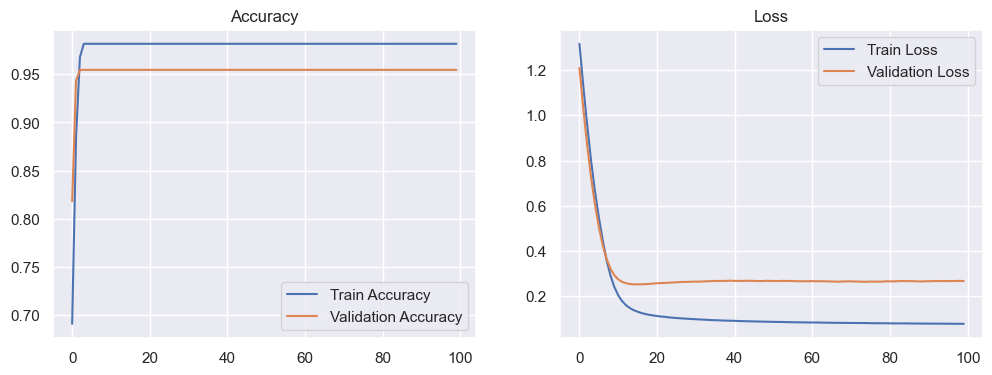

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [22]:
place.to_csv('destinasi_wisata_baru.csv')